# Modelado del valor de los clientes para negocios no contractuales con Python (Customer Lifetime Value - CLV)

En el área de retail o e-commerce, la relación entre negocios y clientes es una relación no-contractual. Los clientes pueden dejar de comprarnos, pero lo hacen de forma silenciosa, ya que no tienen ninguna obligación en decirnos que nos dejan. Esto hace mas complicado el ánalisis de qué tan importante es ese cliente para nosotros. 

Debemos mirar el período de tiempo desde la última compra de cliente y preguntarnos: Está el cliente "vivo" (todavía interactúa con nosotros) o "muerto" (inactivo como cliente).

Para responder a eso se va a modelar el valor de estos clientes para negocios no contractuales.

El dataset utilizado corresponde a una empresa de e-commerce británica, con datos de todas las transacciones realizadas en el periodo de un año (2010 -2011).

## Cargando los datos

In [3]:
# IMPORTS

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel("Online_Retail_Datos.xlsx")

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Limpiando los datos

In [6]:
import datetime as dt

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date #Se lleva al formato de tiempos manejado por pandas

df = df[pd.notnull(df['CustomerID'])] #Quitando valores nulos

df = df[(df['Quantity']>0)] # Quitando valores erróneos de cantidades

df['Sales'] = df['Quantity'] * df['UnitPrice']  # valor total vendido

columnas_de_interes = ['CustomerID', 'InvoiceDate', 'Sales'] # lista con las columnas que se van a analizar

df = df[columnas_de_interes]

print(df.head())
print(df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4339


## Implementación de CLV

### Definición:

* La frecuencia (Frequency = F) representa el número de compras repetidas que ha realizado el cliente. Esto significa que es uno menos que el número total de compras.
* Tiempo (Time = T) representa la edad del cliente en las unidades de tiempo elegidas (diariamente, en nuestro conjunto de datos). Es igual a la duración entre la primera compra de un cliente y el final del período en estudio.
* La antigüedad (R = Recency) representa la edad del cliente cuando realizó sus compras más recientes. Esto es igual a la duración entre la primera compra de un cliente y su última compra. (Por lo tanto, si solo han realizado una compra, la antigüedad es 0).

Se va a utilizar la librería "lifetimes" desarrollada por la empresa Shopify.

In [7]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


CustomerID 12346 realizó 1 compra solamente (sin repetición), por lo que su frecuencia y antigüedad son 0, y su edad es 325 días (por ejemplo, la duración entre su primera compra y el final del período en el análisis).

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


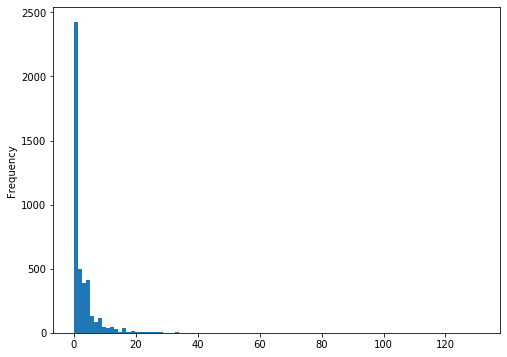

In [8]:
plt.figure(figsize=(8,6))
data['frequency'].plot(kind='hist', bins=100)

print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

Entre todos los clientes de nuestros datos, más del 35% de ellos solo realizó una compra una vez (sin repetición).

## Análisis de frecuencia usando el modelo BG

#### Modelo BG/NBD:

Este modelo fue desarrollado para describir el comportamiento de compra repetida en un entorno donde los clientes compran a un ritmo constante (aunque de manera estocástica) durante un período de tiempo, y luego se vuelven inactivos (abandonan).

Más información en cuanto a las suposiciones y fórmulas matemáticas utilizadas en: https://www.analyticslane.com/2018/06/13/modelos-bg-nbd-para-clv/

In [77]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 49.41, b: 0.00, r: 0.59>


### Graficando la matriz de frecuencia

Un cliente ha realizado una compra todos los días durante cuatro semanas seguidas, y luego no hemos sabido nada de él en meses. ¿Cuáles son las posibilidades de que todavía esté "vivo"? Bastantes bajas. 

Por otro lado, un cliente que históricamente hizo una compra una vez por trimestre, y nuevamente el último trimestre, probablemente todavía esté vivo. 

Se puede visualizar esta relación usando la matriz de frecuencia / actualidad, que calcula el número esperado de transacciones que un cliente artificial debe realizar en el próximo período de tiempo, dada su antigüedad (edad en la última compra) y frecuencia (la cantidad de transacciones repetidas que realiza).

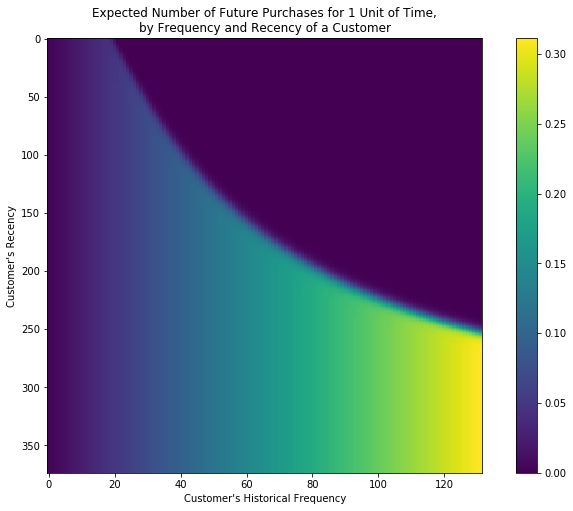

In [78]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

Si un cliente ha realizado 120 compras y su última compra fue cuando tenía aproximadamente 350 días (es decir, antigüedad: la duración entre su primera transacción y su última transacción es de 350 días), entonces él es nuestro mejor cliente (abajo a la derecha). .

Los clientes que han comprado mucho y han comprado recientemente probablemente serán los mejores clientes en el futuro. Nunca tendremos suficientes de ellos.

Los clientes que han comprado mucho pero no recientemente (esquina superior derecha) probablemente se hayan ido.

También hay otro tipo de clientes que ronda (40, 300) que representa al cliente que compra con poca frecuencia, y no lo hemos visto recientemente, por lo que podría volver a comprar. Sin embargo, no estamos seguros de si se ha ido o simplemente entre compras.

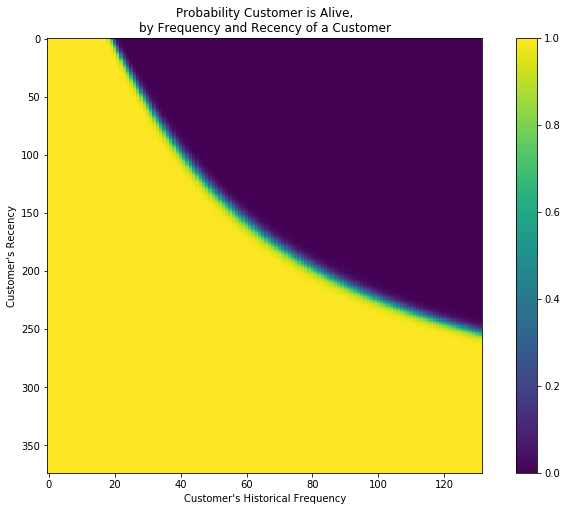

In [79]:
# Prediciendo que clientes volveran a comprar:

from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Es casi seguro que los clientes que han comprado recientemente estén "vivos".

Es probable que los clientes que hayan comprado mucho pero no recientemente lo hayan abandonado. Y cuanto más compraron en el pasado, es más probable que se hayan retirado. Están representados en la parte superior derecha.

Clasificamos a los clientes desde las "compras esperadas más altas en el próximo período" hasta las más bajas. Los modelos exponen un método que predecirá las compras esperadas de un cliente en el próximo período utilizando su historial.

In [80]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      data['frequency'], 
                                                                                      data['recency'], 
                                                                                      data['T'])

data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.209731
15311.0,89.0,373.0,373.0,677.729438,0.212099
17841.0,111.0,372.0,373.0,364.452162,0.264180
12748.0,113.0,373.0,373.0,298.360885,0.268915
14911.0,131.0,372.0,373.0,1093.661679,0.311527


En la lista anterior se encuentran nuestros 5 clientes principales que el modelo espera que realicen compras al día siguiente.

La columna predicted_purchases representa su número esperado de compras, mientras que las otras tres columnas representan sus métricas de RF actuales. 

El modelo BG / NBD cree que estas personas realizarán más compras en un futuro cercano, ya que son nuestros mejores clientes actuales.

## Ajustando el modelo

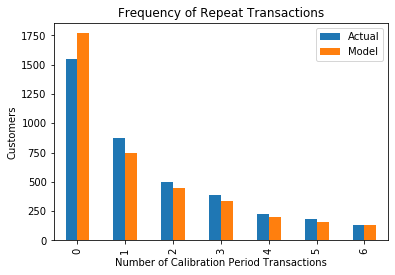

In [81]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

Los resultados que da el modelo son muy similares a los realmente obtenidos.

Se debe separar el dataset en un dataset de "período de calibración" y un dataset de "holdout / retencion". Esto es importante ya que queremos probar cómo funciona nuestro modelo en datos que aún no se han visto (al igual que la validación cruzada en la práctica del aprendizaje automático).

In [82]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                184.0  
12347.0                184.0  
12348.0                184.0  
12350.0                184.0  
12352.0                184.0  


In [83]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2787 subjects, a: 0.00, alpha: 41.27, b: 0.00, r: 0.50>

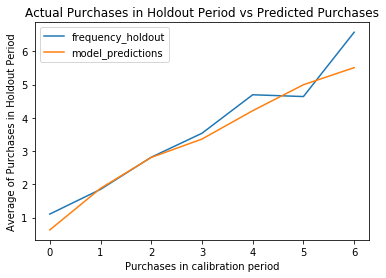

In [84]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

En este gráfico, separamos los datos en un período dentro de la muestra (calibration) y un período de validación (holdout). 

El período de la muestra comprende el comienzo de 2011–06–08; el período de validación se extiende desde 2011–06–09 a 2011–12–09. 

La gráfica agrupa a todos los clientes en el período de calibración por su número de compras repetidas (eje x) y luego promedia sobre sus compras repetidas en el período de reserva (eje y). Las líneas naranja y azul presentan la predicción del modelo y el resultado real del eje y respectivamente. Como podemos ver, nuestro modelo es capaz de predecir con mucha precisión el comportamiento de la base de clientes fuera de la muestra, el modelo subestima en 4 compras y sobrestima en 5 compras.

## Predicciones

In [89]:
t = 10 #periodo
individuo = data.loc[12347] #individuo con ID 12347
bgf.predict(t, individuo['frequency'], individuo['recency'], individuo['T'])

0.15929394518539644

El modelo predice que el cliente 12347 realizará 0.159 compras en 10 dias.

### Historial de probabilidad del cliente

Dado el historial de transacciones de un cliente, podemos calcular su probabilidad histórica de "estar vivo", de acuerdo con nuestro modelo entrenado. Por ejemplo, queremos ver el historial de transacciones de nuestro mejor cliente y ver la probabilidad de "estar vivo" del mismo:

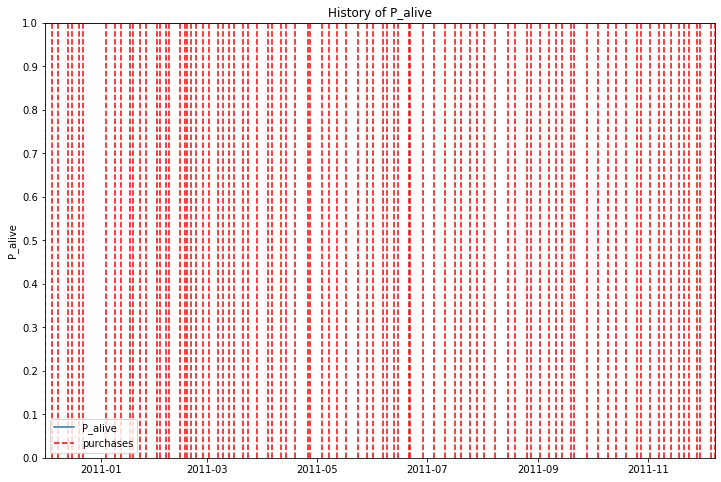

In [90]:
from lifetimes.plotting import plot_history_alive

fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

NOTA: Hay un error en el gráfico, ya que no se muestra P_alive. Consultando la documentación de la librería lifetimes y github no he encontrado respuesta a este error, probablemente debido a algún error entre versiones de las librerías utilizadas.

In [91]:
individuo = data.loc[12347]

In [92]:
individuo

frequency                6.000000
recency                365.000000
T                      367.000000
monetary_value         599.701667
predicted_purchases      0.015834
Name: 12347.0, dtype: float64

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015834
12348.0           3.0    283.0  358.0      301.480000             0.008820
12352.0           6.0    260.0  296.0      368.256667             0.019089
12356.0           2.0    303.0  325.0      269.905000             0.006927
12358.0           1.0    149.0  150.0      683.200000             0.007991
2790


### Estimación del valor de vida útil del cliente mediante el modelo gamma-gamma de valor monetario

Ahora se tiene en cuenta el valor económico de cada transacción. Para estimar esto, se utiliza el submodelo Gamma-Gamma para predecir el gasto probable por transacción en el futuro a nivel de cliente.

Solo se estiman los clientes que tuvieron al menos una compra repetida con nosotros. Por lo tanto, estamos se estiman 2.790 clientes.

In [95]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015834
12348.0           3.0    283.0  358.0      301.480000             0.008820
12352.0           6.0    260.0  296.0      368.256667             0.019089
12356.0           2.0    303.0  325.0      269.905000             0.006927
12358.0           1.0    149.0  150.0      683.200000             0.007991
2790


In [96]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


Una vez aplicado el modelo, se puede estimar el valor promedio de las transacciones de los clientes:

In [101]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64
